# Исследование латентного пространства VAE. Исследование codebook VQ-VAE

## Подгрузка импортов и датасета

In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

sns.set(style="darkgrid", font_scale=1.2, rc={'axes.labelsize': 16, 'legend.fontsize': 14,
                                              'grid.color': '.6', 'grid.linestyle': ':'})

In [2]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 12338037.13it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205539.30it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3890397.26it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7219082.91it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Часть 1. Исследование латентного пространства VAE

В этой части лабораторной работы предлагается обучить обычный VAE. С помощью инструментов снижения размерности (t-SNE или PCA) визуализируйте на плоскости внутреннее пространство VAE.
Альтернативой станет выбор `dim_code=2` и визуализация результатов этого вариационного кодировщика.

In [4]:
class VAE(nn.Module):
    def __init__(self, dim_code=32):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.LeakyReLU(), # 31*31   и 32 канала
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(), # 15*15 и 64 канала
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.LeakyReLU(), # 7*7 и 128 каналов
            nn.Flatten()
        )

        self.mu = nn.Linear(7*7*128, dim_code)
        self.log_var = nn.Linear(7*7*128, dim_code)

        self.decoder_input = nn.Linear(dim_code, 7*7*128)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,  stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3,  stride=2, output_padding=1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )


    def encode(self, x):
        out = self.enc(x)
        mu = self.mu(out)
        log_var = self.log_var(out)
        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.distributions.Normal(0, 1).sample()
            return std * eps + mu
        else:
            return mu

    def decode(self, z):
        out = self.decoder_input(z)
        out = out.view(-1, 128, 7, 7)
        out = self.dec(out)
        return out

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.gaussian_sampler(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var

In [5]:
class VAELoss(nn.Module):
    def __init__(self, kl_weight=1, mse_weight=1):
        super().__init__()
        self.kl_weight = kl_weight
        self.mse_weight = mse_weight
        self.mse = nn.MSELoss()

    def _kl_loss(self, mu, log_var):
        return torch.mean(- 1 / 2 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    def forward(self, x, reconstruction, mu, log_var):
        return self.kl_weight * self._kl_loss(mu, log_var) + self.mse_weight * self.mse(x, reconstruction)

In [6]:
def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device):
    train_loss = []

    for i in range(epochs):
        model.to(device)
        model.train()
        train_epoch_loss = []
        tqdm_iter = tqdm(dataloader)
        for batch in tqdm_iter:
            images, _ = batch
            images = images.to(device)

            optimizer.zero_grad()

            pred = model(images)
            reconstructed, mu, log_var = pred
            loss = criterion(images, reconstructed, mu, log_var)

            loss.backward()
            optimizer.step()
            tqdm_iter.set_postfix(loss=f'{loss.item():.3f}')
            train_epoch_loss.append(loss.item())  ### не было отступа
        train_loss.append(np.mean(train_epoch_loss))
        tqdm_iter.set_postfix(loss=f'{train_loss[-1]:.5f}')


        clear_output()
        fig, ax = plt.subplots(figsize=(8, 4))
        ax = sns.lineplot(x=range(1, i + 2), y=train_loss, marker='o', color='k', label='train loss')
        ax.set(xlabel='num epochs', ylabel='loss', title='model training')
        ax.legend()
        ax.grid(True)
        plt.show()
    return train_loss

## Попробуем взять несколько значений размерности латентного пространства и затем сравнить их

1. dim_code = 32
2. dim_code = 2
3. dim_code = 16

Предлагается с помощью инструментов снижения размерности (t-SNE или PCA) визуализировать на плоскости внутреннее пространство VAE. Попробую и PCA, и T-SNE.

# 1. dim_code = 32

In [7]:
criterion = VAELoss(kl_weight=0.5, mse_weight=1)
model = VAE(dim_code=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

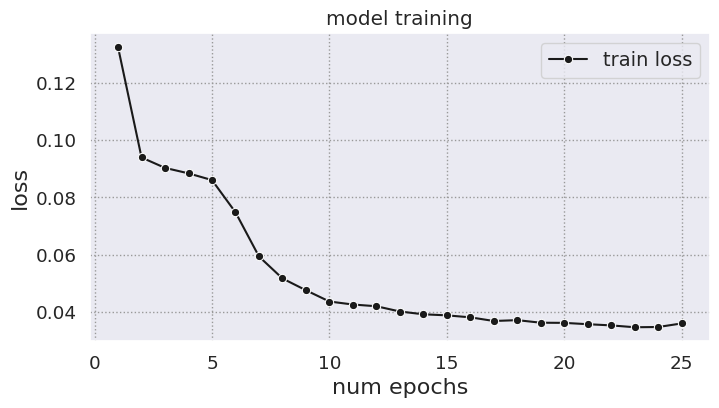

In [8]:
loss = train_autoencoder(
    model=model,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)


In [9]:
def visualize_latent_space(model, dim_reduce_method, n_components=2, device=device, dataloader=testloader):
    model.eval()
    latents, labels = [], []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)

            mu, _ = model.encode(images)

            latents.append(mu.cpu())
            labels.append(label.cpu())

    latents, labels = torch.cat(latents), torch.cat(labels)
    latents, labels = latents.numpy(), labels.numpy()

    # непосредственно применение метода снижения размерности
    if dim_reduce_method == 'PCA':
      pca = PCA(n_components=n_components)
      latents_2d = pca.fit_transform(latents)

      explained_variance_percent = pca.explained_variance_ratio_ * 100

      for i, variance in enumerate(explained_variance_percent, 1):
          print(f"Component {i}: {variance:.2f}%")

    elif dim_reduce_method == 'TSNE':
      tsne = TSNE(n_components=n_components)
      latents_2d = tsne.fit_transform(latents)

    # визуализация
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(ax.collections[0])
    ax.set(title=f"visualization of latent space using {dim_reduce_method}", xlabel="first principal component", ylabel="second principal component")
    ax.grid(True)
    plt.show()


### 1а) PCA

Component 1: 17.51%
Component 2: 13.87%


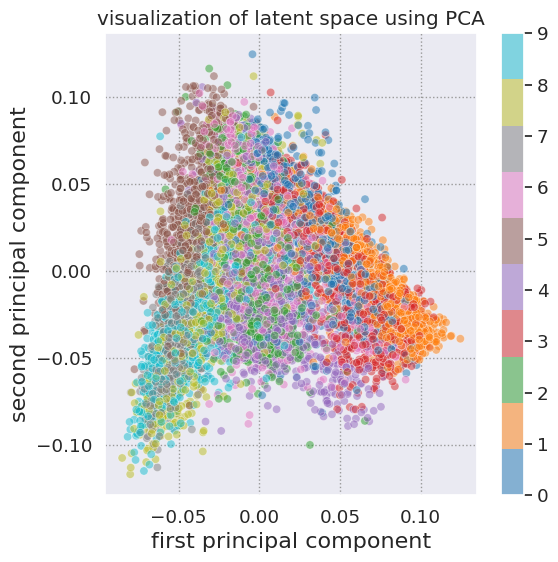

In [10]:
visualize_latent_space(model, 'PCA')

### 1б) TSNE

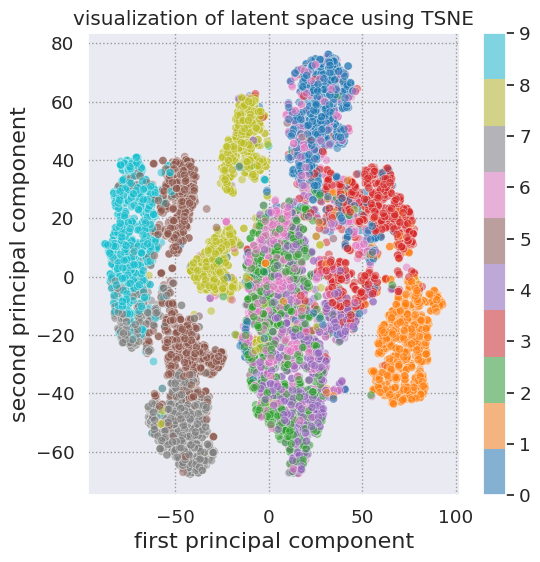

In [11]:
visualize_latent_space(model, 'TSNE')

## 2. dim_code = 2

In [12]:
criterion = VAELoss(kl_weight=0.5, mse_weight=1)
model2 = VAE(dim_code=2)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

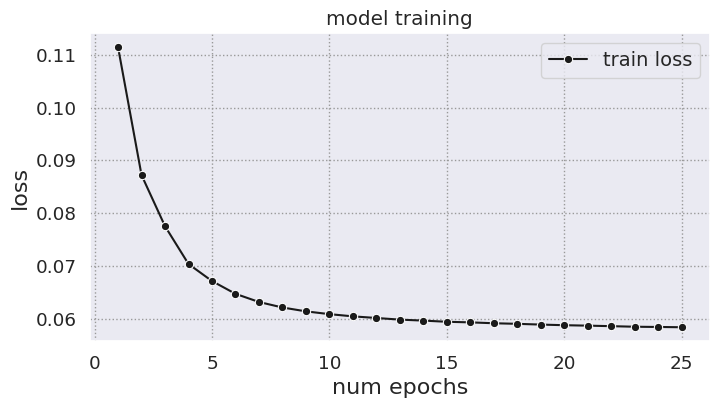

In [13]:
loss = train_autoencoder(
    model=model2,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

### 2а) PCA

Component 1: 99.98%
Component 2: 0.02%


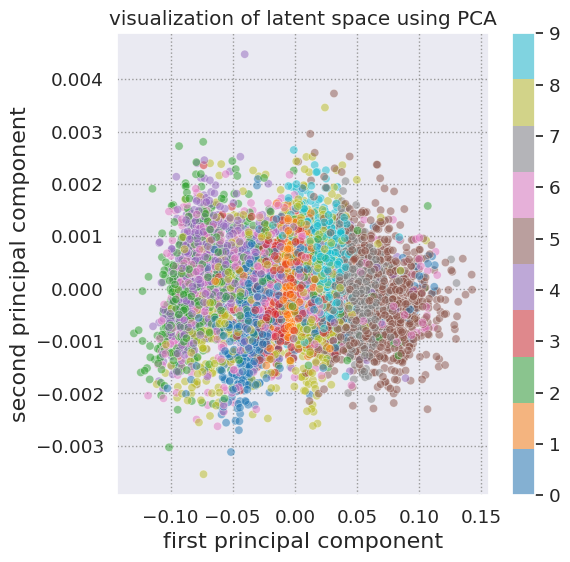

In [14]:
visualize_latent_space(model2, 'PCA')

### 2б) TSNE

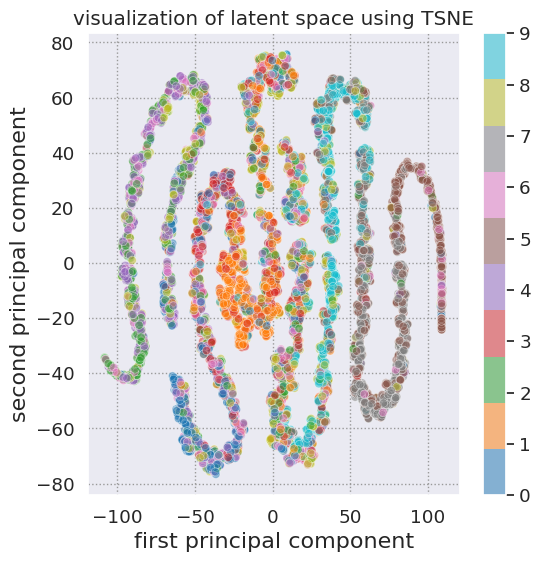

In [15]:
visualize_latent_space(model2, 'TSNE')

## 3. dim_code = 16

In [16]:
criterion = VAELoss(kl_weight=0.5, mse_weight=1)
model3 = VAE(dim_code=16)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)
epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

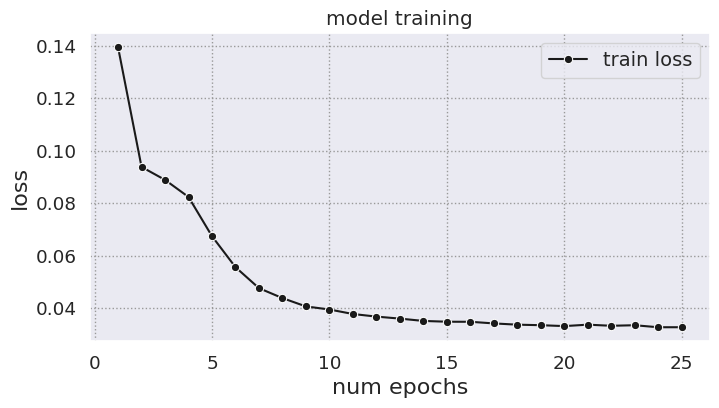

In [17]:
loss = train_autoencoder(
    model=model3,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

### 3а) PCA

Component 1: 16.63%
Component 2: 13.96%


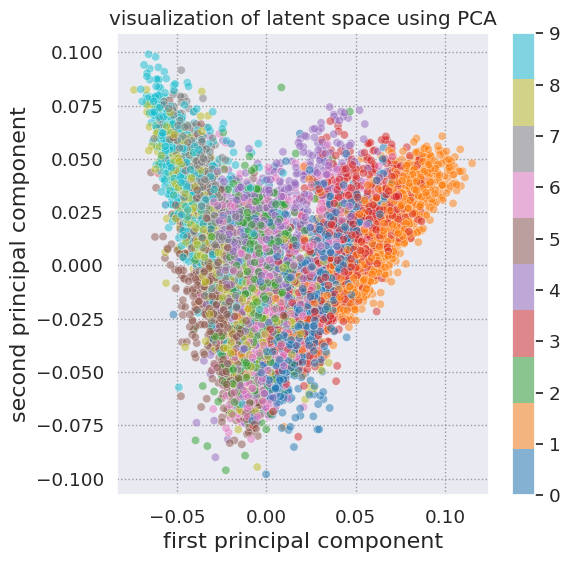

In [18]:
visualize_latent_space(model3, 'PCA')

### 3б) TSNE

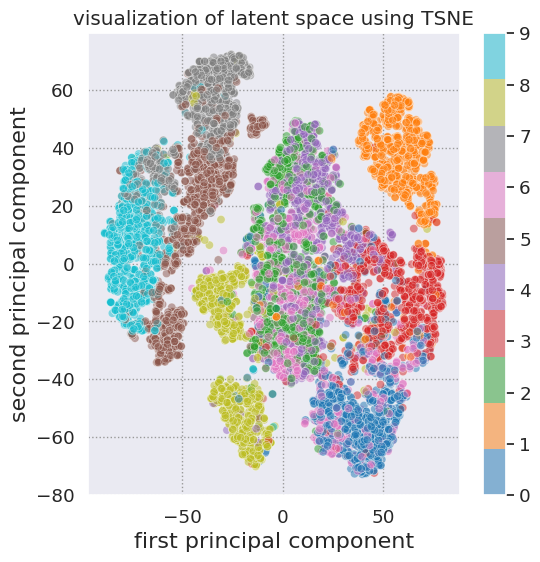

In [19]:
visualize_latent_space(model3, 'TSNE')

## Часть 2. Исследование codebook VQ-VAE

Исследуйте влияние гиперпараметров `embedding_dim, num_embeddings` на генерацию и сходимость VQ-VAE. В пределах каких значений генерация лучше? В пределах каких значений сходится кодировщик? От чего зависит диапазон значений для модели?

In [20]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=10, embedding_dim=128):
        super(VectorQuantizer, self).__init__()
        # размерность и колво векторов codebook, + сама codebook с равномерным распр при инициализации
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous() # переставляем оси тензора из размер батча * число каналов * высота * ширина в размер батча * ширина * высота * число каналов
        input_shape = inputs.shape

        flat_input = inputs.view(-1, self._embedding_dim) # выпрямление вектора

        # расстояния между векторами codebook и входом
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) + torch.sum(self._embedding.weight**2, dim=1) - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # ближайший ко входу вектор codebook

        # матрицы индексов с индексами векторов codebook
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape) # квантизуем  матрицу для обучения матрицы весов
        quantized = inputs + (quantized - inputs).detach() # копирование градиентов из inputs в quantized

        return quantized.permute(0, 3, 1, 2).contiguous() # обратное переставление осей тензора

In [21]:
class QuantizerLoss(nn.Module):
    def __init__(self, commitment_cost):
        super().__init__()
        self.commitment_cost = commitment_cost
        self.mse = nn.MSELoss()

    def forward(self, z, quantized):
        return self.mse(quantized.detach(), z) + self.commitment_cost * self.mse(quantized, z.detach())

In [22]:
class VQVAELoss(nn.Module):
    def __init__(self, commitment_cost=0.5):
        super().__init__()
        self.recon = nn.MSELoss()
        self.quantizer = QuantizerLoss(commitment_cost)

    def forward(self, x, recon, z, quantized):
        return self.recon(x, recon) + self.quantizer(z, quantized)

In [23]:
class VQVAE(nn.Module):
    def __init__(
            self,
            num_embeddings=10,
            embedding_dim=128,
            ):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.LeakyReLU(),
        )

        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,  stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3,  stride=2, output_padding=1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )


    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        z = self.encode(x)
        quantized = self.quantizer(z)
        out = self.decode(quantized)
        return out, z, quantized

### Исследование влияния гиперпараметров на результаты обучения

In [24]:
num_embeddings_list = [10, 25, 50, 100]
embedding_dim_list = [16, 32, 64, 128]
epochs = 10

In [25]:
# Функция для обучения модели с гиперпараметрами
def train_vqvae(num_embeddings, embedding_dim, dataloader, epochs=epochs, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model_vqvae = VQVAE(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    criterion = VQVAELoss(commitment_cost=0.5)
    optimizer = torch.optim.Adam(model_vqvae.parameters(), lr=0.0001)

    train_loss = []
    for i in range(epochs):
        model_vqvae.to(device)
        model_vqvae.train()
        train_epoch_loss = []
        tqdm_iter = tqdm(dataloader)
        for batch in tqdm_iter:
            images, _ = batch
            images = images.to(device)

            optimizer.zero_grad()
            pred = model_vqvae(images)
            reconstructed, z, quantized = pred
            loss = criterion(images, reconstructed, z, quantized)

            loss.backward()
            optimizer.step()
            train_epoch_loss.append(loss.item())
        train_loss.append(np.mean(train_epoch_loss))

    return train_loss

100%|██████████| 1875/1875 [00:26<00:00, 71.23it/s]


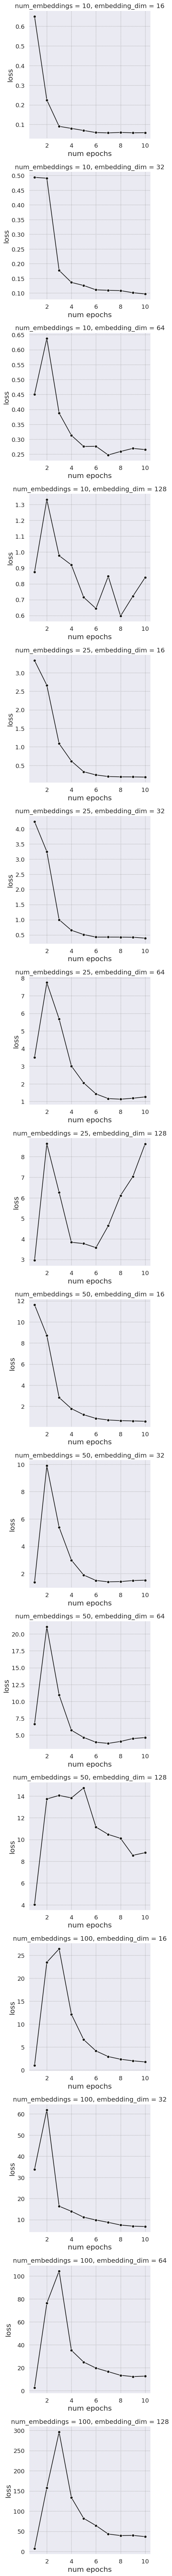

In [26]:
fig, axs = plt.subplots(len(num_embeddings_list) * len(embedding_dim_list), figsize=(5, 5*len(num_embeddings_list) * len(embedding_dim_list)))

for i, num_embeddings in enumerate(num_embeddings_list):
    for j, embedding_dim in enumerate(embedding_dim_list):
        train_loss = train_vqvae(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            dataloader=dataloader
        )

        sns.lineplot(x=range(1, epochs + 1), y=train_loss, marker='o', color='k', ax=axs[len(embedding_dim_list)*i + j])
        axs[len(embedding_dim_list)*i + j].set(title=f'num_embeddings = {num_embeddings}, embedding_dim = {embedding_dim}', xlabel='num epochs', ylabel='loss')
        axs[len(embedding_dim_list)*i + j].grid(True)

plt.tight_layout()
plt.show()

При минимальных значенияъ размерности векторов и их количестве получился наилучший результат (имеется в виду при минимальных значениях в сетке гиперпараметров). Думаю, что это связано с тем, что разнообразие имеющихся данных не слишком большое.